In [34]:
import numpy as np
import matplotlib.pyplot as plt
from anthony.aes import sub_bytes, add_round_key
from peakutils.peak import indexes

num_traces = 150
num_samples = 50000
num_key_bytes = 16

all_hamming_weights_per_box_1 = np.zeros((150, 256, 16), dtype=np.uint8)
all_hamming_weights_per_box_2 = np.zeros((150, 256, 16), dtype=np.uint8)
coeff_1 = np.zeros((16, 256))
coeff_2 = np.zeros((16, 256))

In [2]:
def hamming_weight(n):
    count = 0
    while n:
        count += n & 1
        n >>= 1
    return count

hamming_weights = np.array([hamming_weight(i) for i in range(256)])

In [3]:
plaintexts_1 = np.zeros((150, 16), dtype=int)

with open(f"data/dataset1/cleartext.txt", "r") as file:
	for i, line in enumerate(file):
		plaintexts_1[i] = np.array(line.strip().split(), dtype=int)

In [4]:
plaintexts_2 = np.zeros((150, 16), dtype=int)

with open(f"data/dataset2/cleartext.txt", "r") as file:
	for i, line in enumerate(file):
		plaintexts_2[i] = np.array(line.strip().split(), dtype=int)

In [5]:
all_traces_1 = np.zeros((16, 150, 50000), dtype=float)

for i in range(16):
        with open(f"data/dataset1/trace{i}.txt") as f:
            for t, line in enumerate(f):
                all_traces_1[i][t] = np.array(line.strip().split(), dtype=np.float64)

In [6]:
all_traces_2 = np.zeros((16, 150, 50000), dtype=float)

for i in range(16):
	with open(f"data/dataset2/trace{i}.txt") as f:
		for t, line in enumerate(f):
			all_traces_2[i][t] = np.array(line.strip().split(), dtype=np.float64)

In [7]:
all_clocks = np.zeros((16, 150, 50000), dtype=float)

for i in range(16):
	with open(f"data/dataset2/clock{i}.txt") as f:
		for t, line in enumerate(f):
			all_clocks[i][t] = np.array(line.strip().split(), dtype=np.float64)

# Get all hamming weights for dataset 1

In [8]:
for key_guess in range(256):
    key_guess_matrix = np.full((4, 4), key_guess, dtype=np.uint8)
    for tnum, in_data in enumerate(plaintexts_1):
        in_matrix = np.asarray(in_data, dtype=np.uint8).reshape(4, 4)

        added_key = add_round_key(in_matrix, key_guess_matrix)
        sub_out = sub_bytes(added_key, False).flatten()

        for byte_index in range(sub_out.shape[0]):
            all_hamming_weights_per_box_1[tnum][key_guess][byte_index] = hamming_weights[sub_out[byte_index]]

# Get all hamming weights for dataset 2

In [9]:
for key_guess in range(256):
    key_guess_matrix = np.full((4, 4), key_guess, dtype=np.uint8)
    for tnum, in_data in enumerate(plaintexts_2):
        in_matrix = np.asarray(in_data, dtype=np.uint8).reshape(4, 4)

        added_key = add_round_key(in_matrix, key_guess_matrix)
        sub_out = sub_bytes(added_key, False).flatten()

        for byte_index in range(sub_out.shape[0]):
            all_hamming_weights_per_box_2[tnum][key_guess][byte_index] = hamming_weights[sub_out[byte_index]]

In [10]:
master_key_1 = np.array([65, 117, 115, 116, 114, 97, 108, 111, 112, 105, 116, 104, 101, 99, 117, 115])

In [11]:
coeffs_plot = np.zeros((256, 50000), dtype=np.float64)

In [12]:
coeffs_temp = np.zeros((256, 50000), dtype=np.float64)

# Get coefficients for a single box

# ATTENTION: the below code block uses the `coeffs_plot` array. Do not modify this version. Use the block just below this one instead for test becuase that's the one that uses `coeffs_temp` instead!

In [13]:
maxes = np.zeros(256, dtype=np.float64)
for guess in range(256):
	guess_box_weights = all_hamming_weights_per_box_1[:, guess, 0] #! 1 or 2
	WxH = (all_traces_1[0].T * guess_box_weights).T #! 1 or 2
	EWxH = np.sum(WxH, axis=0)

	Ew = np.sum(all_traces_1[0], axis=0) #! 1 or 2

	Eh = np.sum(guess_box_weights)

	Ew2 = np.sum(np.square(all_traces_1[0]), axis=0) #! 1 or 2
	Ew_squared = np.square(Ew)  # constant

	Eh2 = np.sum(np.square(guess_box_weights), axis=0)
	Eh_squared = np.square(Eh)

	top = (150 * EWxH) - (Eh * Ew)
	bottom = np.sqrt((150 * Ew2) - Ew_squared) * np.sqrt((150 * Eh2) - Eh_squared)
	coeffs_plot[guess, :] = np.abs(top / bottom) #! coeffs_plot is here!
	maxes[guess] = np.max(np.abs(top / bottom))

In [14]:
maxes = np.zeros(256, dtype=np.float64)
x = 15
for guess in range(256):
	guess_box_weights = all_hamming_weights_per_box_1[:, guess, x] #! 1 or 2
	WxH = (all_traces_1[x].T * guess_box_weights).T #! 1 or 2
	EWxH = np.sum(WxH, axis=0)

	Ew = np.sum(all_traces_1[x], axis=0) #! 1 or 2

	Eh = np.sum(guess_box_weights)

	Ew2 = np.sum(np.square(all_traces_1[x]), axis=0) #! 1 or 2
	Ew_squared = np.square(Ew)  # constant

	Eh2 = np.sum(np.square(guess_box_weights), axis=0)
	Eh_squared = np.square(Eh)

	top = (150 * EWxH) - (Eh * Ew)
	bottom = np.sqrt((150 * Ew2) - Ew_squared) * np.sqrt((150 * Eh2) - Eh_squared)
	coeffs_temp[guess, :] = np.abs(top / bottom) #! note that coeffs_temp is used here!

# Get coefficients for all boxes

In [15]:
maxes = np.zeros(256, dtype=np.float64)
plt.figure(figsize=(8, 4))
def multi(box: int):
	print(f'{box=}')
	for guess in range(256):
		guess_box_weights = all_hamming_weights_per_box_1[:, guess, box] #! 1 or 2 AND BOX!!
		WxH = (all_traces_1[box].T * guess_box_weights).T #! 1 or 2
		EWxH = np.sum(WxH, axis=0)

		Ew = np.sum(all_traces_1[box], axis=0) #! 1 or 2

		Eh = np.sum(guess_box_weights)

		Ew2 = np.sum(np.square(all_traces_1[box]), axis=0) #! 1 or 2
		Ew_squared = np.square(Ew)  # constant

		Eh2 = np.sum(np.square(guess_box_weights), axis=0)
		Eh_squared = np.square(Eh)

		top = (150 * EWxH) - (Eh * Ew)
		bottom = np.sqrt((150 * Ew2) - Ew_squared) * np.sqrt((150 * Eh2) - Eh_squared)
		coeffs_plot[guess, :] = top / bottom

	# plt.plot(coeffs_plot[4], 'red', linewidth=0.5)
	plt.plot(coeffs_plot[master_key_1[box]], f'C{box}', linewidth=0.5)
	# plt.plot(coeffs_plot[6], 'blue', linewidth=0.5)

	plt.title('coefficient comparison')
	plt.xlabel('Index')
	plt.ylabel('Value')

<Figure size 800x400 with 0 Axes>

# ATTENTION: don't execute this below code block. Again, if you need to use it for testing stuff, copy it somewhere else and use some other variable different that `coeffs_plot`.

box=0
box=1
box=2
box=3
box=4
box=5
box=6
box=7
box=8
box=9
box=10
box=11
box=12
box=13
box=14
box=15


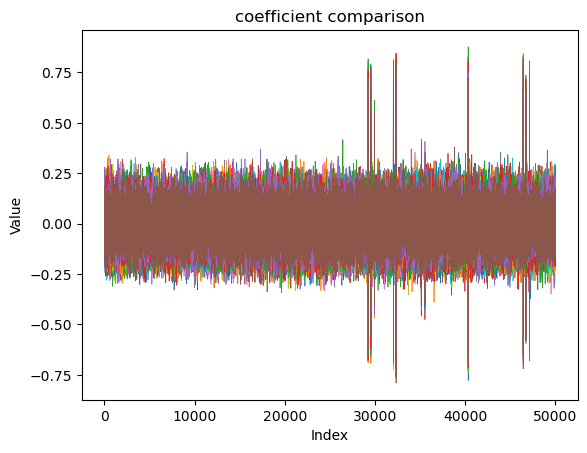

In [16]:
for i in range(16):
	multi(i)

plt.show()

# Testing stuff

# ATTENTION: do not modify arrays here, use this section for reading data. DO NOT modify the data.

In [17]:
np.where(coeffs_plot == np.max(coeffs_plot))

(array([115]), array([46435]))

In [18]:
all_clocks[15][0].shape

(50000,)

# Plotting

# ATTENTION: DO NOT change the following plots. Copy and paste the code to some other cell block and play with them there.

## indexing guide
### all_traces [ box ] [ input_index ] [ samples ]

Look at the below plot. The **green**, **black**, and **brown** lines are the correlation peaks for a particular byte. Each show a `200` sample range of each of these correlation plots around each of the highest peak locations found at the end of this notebook (there are **3** sample locations that give the highest correlation: `46435`, `32335`, `40335`). We can clearly see that there isn't a significant difference between the peaks at each of these ranges.

What does this mean? Well let's remember that correlation peaks by themselves. There are multiple distinguishable peaks (Look at the plot above labeled `coefficient comparison`). So how do we know which one we need to focus on? We can see with the below analysis that we can focus on any one of the **3** max peak locations. Since `46435` is the most common, we need to find that area in the **dataset2** traces, find how many clock cycles until that area is reached, then use the number of clock signals to grab the rest of these "regions of interest" from the rest of the traces.

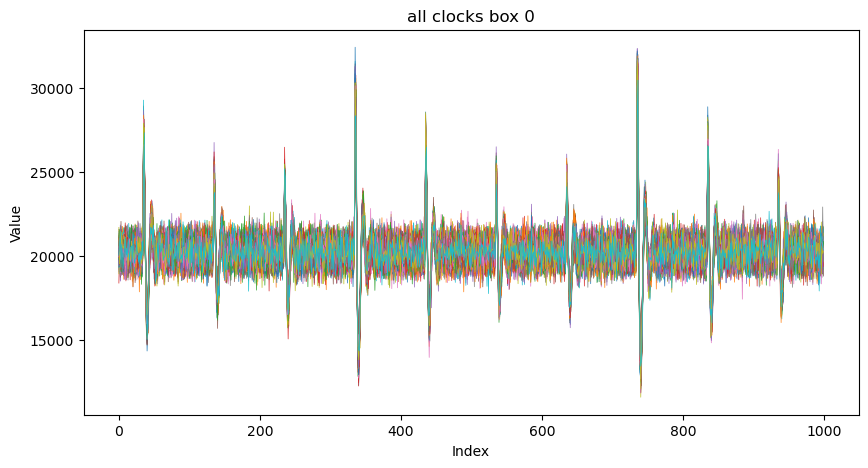

peaks are [ 2736  3136  4336  9535 14335 15935 17135 17535 17935 18335 19135 19535
 19935 21135 22335 22735 26335 26735 27135 27535 28335 28735 29535 30335
 30735 31935 32335 33135 33535 33935 34335 34735 35135 35535 36335 36735
 37135 37535 37935 39535 40335 40735 41535 41935 42335 43535 43935 44335
 45135 45535 47135 47535 49135 49535]


In [43]:
plt.figure(figsize=(10, 5))
for j in range(150):
	# plt.plot(all_clocks[0][j][46400:46500], f'C{j}', linewidth=0.5)
	plt.plot(all_traces_1[0][j][:1000], f'C{j}', linewidth=0.5)

# plt.plot(np.abs(coeffs_temp[master_key_1[x]])[46400:46500], 'black', linewidth=1)

plt.title(f'all clocks box 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

t = indexes(np.array(all_traces_1[0][0]), thres=0.7, min_dist=5)
print(f'peaks are {t}')

lags=array([-49999, -49998, -49997, ...,  49997,  49998,  49999])


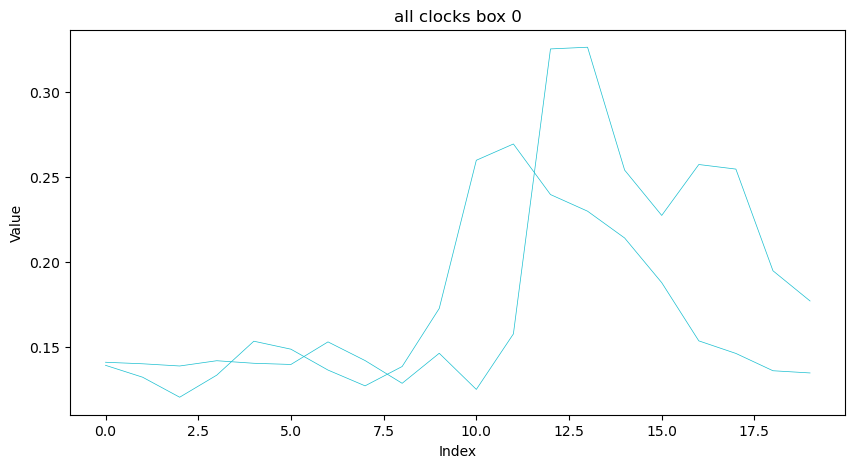

In [50]:
from scipy import signal

correlation = signal.correlate(all_traces_2[0][0], all_traces_2[0][1], mode="full")
lags = signal.correlation_lags(all_traces_2[0][0].size, all_traces_2[0][1].size, mode="full")
print(f'{lags=}')
lag = lags[np.argmax(correlation)]

plt.figure(figsize=(10, 5))
plt.plot(all_traces_2[0][0][60:80], f'C{j}', linewidth=0.5)
plt.plot(all_traces_2[0][1][60:80], f'C{j}', linewidth=0.5)

plt.title(f'all clocks box 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

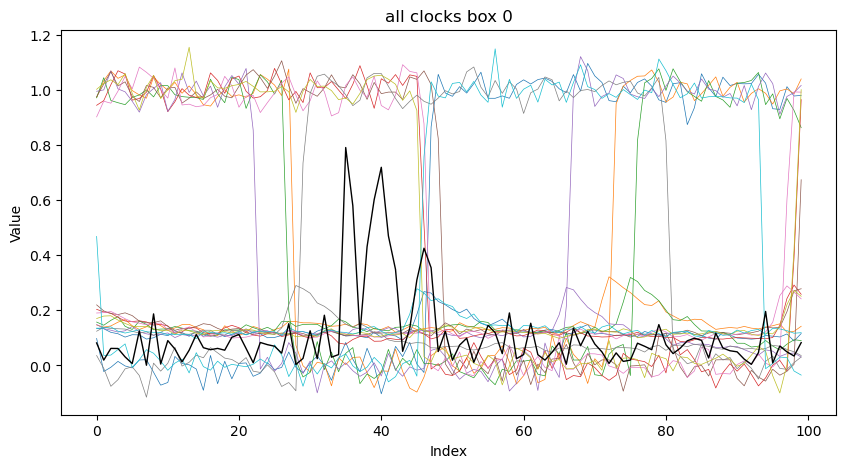

In [20]:
plt.figure(figsize=(10, 5))
for j in range(10):
	plt.plot(all_clocks[0][j][46400:46500], f'C{j}', linewidth=0.5)
	plt.plot(all_traces_2[0][j][46400:46500], f'C{j}', linewidth=0.5)

plt.plot(np.abs(coeffs_temp[master_key_1[x]])[46400:46500], 'black', linewidth=1)

plt.title(f'all clocks box 0')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

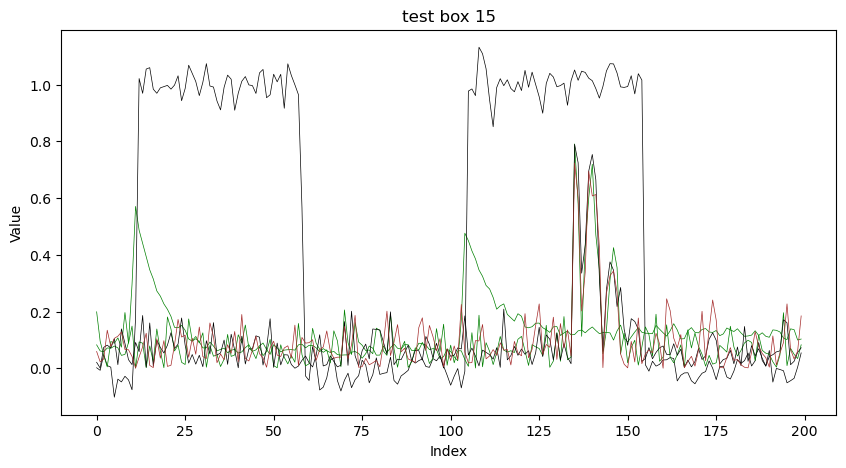

In [21]:
plt.figure(figsize=(10, 5)) #! 46435
plt.plot((all_traces_2[x][0])[46300:46500], 'green', linewidth=0.5)
plt.plot(all_clocks[x][0][46300:46500], 'black', linewidth=0.5)
plt.plot(np.abs(coeffs_temp[master_key_1[x]])[46300:46500], 'green', linewidth=0.5)
plt.plot(np.abs(coeffs_temp[master_key_1[x]])[32200:32400], 'black', linewidth=0.5)
plt.plot(np.abs(coeffs_temp[master_key_1[x]])[40200:40400], 'brown', linewidth=0.5)

plt.title(f'test box {x}')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

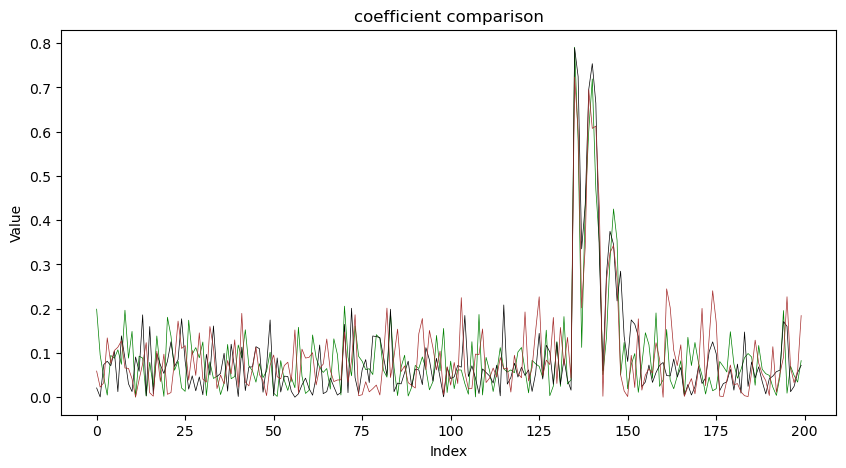

In [22]:
plt.figure(figsize=(10, 5)) #! 46435
# plt.plot((all_traces_1[15][0] / 70000)[46300:46500], 'orange', linewidth=0.5)
# plt.plot((all_traces_2[15][0])[46300:46500], 'red', linewidth=0.5)
# plt.plot(all_clocks[15][0][46300:46500], 'blue', linewidth=0.5)
plt.plot(np.abs(coeffs_plot[master_key_1[15]])[46300:46500], 'green', linewidth=0.5)
plt.plot(np.abs(coeffs_plot[master_key_1[15]])[32200:32400], 'black', linewidth=0.5)
plt.plot(np.abs(coeffs_plot[master_key_1[15]])[40200:40400], 'brown', linewidth=0.5)

plt.title('coefficient comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# plt.figure(figsize=(10, 5)) #! 46435
# plt.plot((all_traces_1[15][1] / 70000)[46300:46500], 'orange', linewidth=0.5)
# plt.plot((all_traces_2[15][1])[46300:46500], 'red', linewidth=0.5)
# plt.plot(all_clocks[15][1][46300:46500], 'blue', linewidth=0.5)
# plt.plot(np.abs(coeffs_plot[master_key_1[15]])[46300:46500], 'green', linewidth=0.5)

# plt.title('coefficient comparison')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.show()

# Correlation peak locations for each byte

### box 0
(array([65]), array([46435]))

### box 1
(array([117]), array([32335]))

### box 2
(array([115]), array([46435]))

### box 3
(array([116]), array([46435]))

### box 4
(array([114]), array([40335]))

### box 5
(array([97]), array([40335]))

### box 6
(array([108]), array([46435]))

### box 7
(array([111]), array([32335]))

### box 8
(array([112]), array([46435]))

### box 9
(array([105]), array([46435]))

### box 10
(array([116]), array([46435]))

### box 11
(array([104]), array([46435]))

### box 12
(array([101]), array([40335]))

### box 13
(array([99]), array([32335]))

### box 14
(array([117]), array([46435]))

### box 15
(array([115]), array([46435]))

## 46435 -> 10 appearances
## 32335 -> 3 appearances
## 40335 -> 3 appearances